Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 08: EEG Processing

## Introduction

This week's sheet should be solved and handed in at 14:00 on **Tuesday, June 25, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this exercise sheet you will start to work with EEG data.

The dataset is from an EEG study, conducted by Artur Czeszumski, Benedikt Ehinger, Basil Wahn and Peter König here at the institue. [Here](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.00361/full) you can find their paper. I highly recommend to at least read the parts where the experimental design and the experimental procedure are described, in order to properly understand how the data was recorded. The whole data is openly distributed on the [Open Science Framework](https://osf.io/c4wkx/). 
Here's how you can access the data that we will work with:
- Go to the section *Files* and select the *Data/EEG/sub408* 
- For all the homework regarding EEG data analysis we will be working with the data of *6_408_RerefInterp.set*. So this is the file you want to download. 
- Store it in the same folder as this notebook, in order to make it easily accessible.

For this task, we will mainly use the [MNE](http://martinos.org/mne), which is an open-source python package for EEG data processing. Since *MNE* has many really nice functions, in this homework you will probably spend more time with reading and thinking than with actual coding.

In [102]:
# For more interactive plot, you can uncomment the following code:
# %matplotlib qt5 

In [24]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
import warnings
warnings.filterwarnings("ignore")

## Assignment 0: Peer review for sheet 06 [3 pts]

As always, you will have to make a peer review of the other groups' solutions. Each group reviews the solutions of two other groups and give points according to the given point distribution considering the correctness of the solution. For this reviews the tutors will give you up to 3 points each week.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 8, 3 | 1, 11  | 10, 8  | 5, 10 | 9, 2 | 11, 5  | 6, 4 | 2, 9  | 4, 6  | 7, 1   | 3, 7   |

## Assignment 1: Looking at the the EEG data [3 pts]

### a) Loading the preprocessed EEG dataset [1 pt]
The first step is to get an idea of the different data types, that are used by MNE. So once we loaded the EEG data, we will look at the *mne.info* attribute, which is like a modified Python dictionary. It stores all the metadata about the recordings. You can access all the keys by calling *raw.key*. The info-attribute tells you of what type the key-specific output will be.
E.g. *preprocessed.ch_names* will return a list of strings containing all channel-names. 

- Print the metadata of the recorings
- Print all channel-names as a list
- Call preprocessed.plot() and limit the number of channels to be displayed at once to 10 in order to have a first look at the EEG recordings.

*Info: Since the data has already been preprocesed (filtered, cleaned, etc.) with the EEGLAB toolbox in Matlab, not all the metadata is correctly transferred by MNE (e.g. the values for highpass and lowpass filters in the .info attribute are not correct, in the study they used a 0.1Hz HP filter and a 120Hz LP filter). For our purpose however, this does not matter. Yet, in general it would be recommendable to do both, preprocessing and analysis, with the same toolbox.*

In [25]:
 # We set the log-level to 'WARNING' so the output is less verbose
mne.set_log_level('WARNING')

# create path to file where all EEG Data is stored
home = os.getcwd() + '\\'
setpath = home + 'Data\\'
if not os.path.isdir(setpath):
    os.mkdir(setpath)

# load the preprocessed EEG data and display info-attribute
setname = "6_408_RerefInterp.set"
fname = setpath + setname
preprocessed = mne.io.read_raw_eeglab(fname, preload= True)

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, ...
    chs : list | 66 items (EEG: 65, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 67 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 256.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 66
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 512.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layou

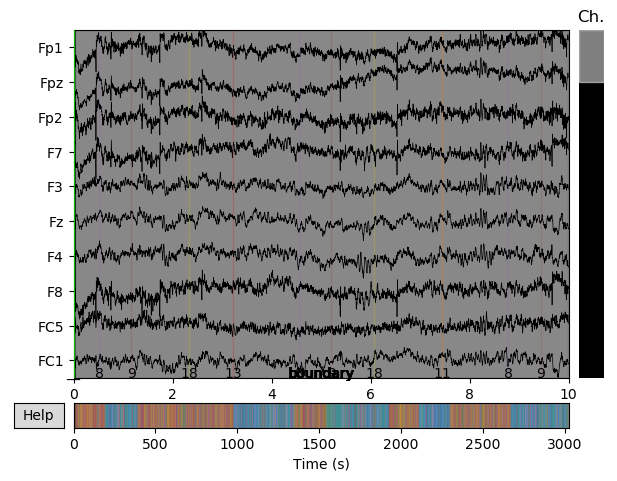

In [44]:
# view the info attribute and see what it contains
print(preprocessed.info)

# print all channel-names
print(preprocessed.ch_names)

# plot all the data, only display 10 channels at once
preprocessed.plot(n_channels = 10)

In order to get an idea about the location of the channels, you can run this cell. Here we read all the montages that are stored within MNE. A montage relates the channels' names to standardized or actual locations on the scalp surface. We will plot the standard *10-20 system*, since this is the one that was used for our recordings.

In [32]:
# First, list all montages that ship with mne:
mne.channels.get_builtin_montages()
# choose the 10-20 system and plot the a map of the scalp
montage = mne.channels.read_montage("standard_1020")
montage.plot()

#assign this montage to our preprocessed object
preprocessed.set_montage(montage)

<RawEEGLAB  |  6_408_RerefInterp.set, n_channels x n_times : 66 x 1546814 (3021.1 sec), ~779.0 MB, data loaded>

### b) Select and plot a data segment [2 pts]
Now we will look at the preprocessed data, selecting a certain segment in time and some channels that we want plot.

Generally the EEG data can be accessed as:  
*data, times = preprocessed[picks, time_slice]*  
... here *picks* selects the channels that you want to focus on, calling them by their index  

You can get all the data simply by:  
*data, times = preprocessed[ : ]*  

Which is equivalent to:  
*data, times = preprocessed[ :, :]*  

With this information: 
- Write a function that plots a segment of the data, given a certain time-interval and a list of channels: Use it to plot a data segment between 100 and 115s and specifically select the midline frontal electrodes ['F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2'] with the *picks*-argument. In the paper mentioned above you can read more about why we focus on exactly these channels. 
- Print *times.shape* and *data.shape* before and after segmenting the data, in order to get an idea of their dimensions. The shapes of the two arrays (*data* and *times*) explain why we need to take the transpose of the data-array in order to be able to plot it.
- First plot all the channels together by simply plotting *times* and *data*. 
- Then plot all channels separatly in subplots.

**Hints:**  
1. For *picks*, you will have to use *.ch_names.index('channel-name')* in order to get the index of the electrode-names that you want to select.  
2. Also note that if you just slice your data with for example *data, times = preprocessed[:, :10]*, you are not selecting a time interval in seconds but only time steps or samples (here the first 10 time steps). This means, that you will first have to find the sample-index of your time-in-seconds interval. For this use *preprocessed.time_as_index([segment_in_seconds])*. 

In [35]:
# acces all data:
data_all, times_all = preprocessed[:]
# a look at the dimensionality explains the need to transpose
print(data_all.shape)
print(times_all.shape)

(66, 1546814)
(1546814,)


In [48]:
# write a function that plots the segment of the data, given a certain time-interval and a list of channels

def plotSegment(segment, channels):
    # choose a data segment between 100s to 115s
    start, stop = preprocessed.time_as_index(segment)
    
    # make a list of channel indices
    ch_indices = []
    for i in channels:
        ch_indices.append(preprocessed.ch_names.index(i))
    
    # segment the data and display shape again    
    data, times = preprocessed[ch_indices, start:stop+1]
    print(data.shape)
    print(times.shape)
    
    # in order to check whether you sliced your data correctly, print:
    print(times.min(), times.max())
    
    # make the plot
    p = plt.plot(times, data.T)
    
    return p

# plot data from midline frontal elctrodes
ch_select = ['F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2']
plotSegment([100,115], ch_select)

(6, 7681)
(7681,)
100.0 115.0


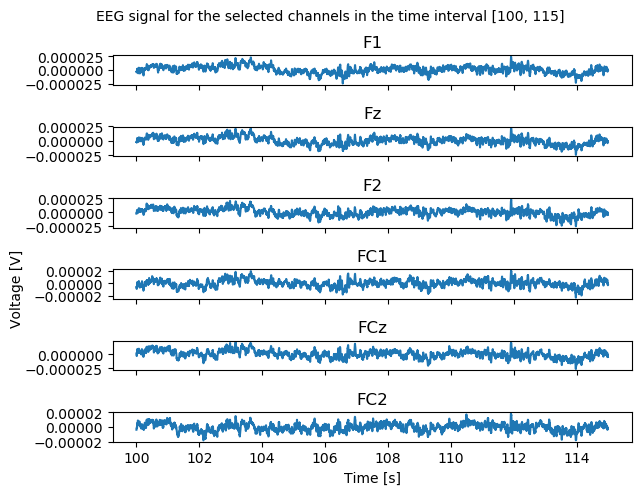

In [101]:
# plot all channels separately
def plotChannelSegment(segment, channels):
    # choose a data segment between 100s to 115s
    start, stop = preprocessed.time_as_index(segment)
    fig, axes = plt.subplots(nrows=len(channels), sharex=True)
    for n,c in enumerate(channels):
        # get channel index
        ind = preprocessed.ch_names.index(c)
        # slice up the data:
        data, times = preprocessed[ind, start:stop]
        # make the plot
        axes[n].plot(times, data.T)
        axes[n].set(title=c)
        # set common x-label
        if n == 5:
            axes[n].set_xlabel('Time [s]')
    # set common ylabel and titel
    fig.text(0, 0.5, 'Voltage [V]', rotation='vertical')
    fig.text(0.5, 1, 'EEG signal for the selected channels in the time interval [100, 115]', ha='center')
    fig.tight_layout()
    return fig

# create plot with the same data as before
plotChannelSegment([100,115], ch_select)

## Assignment 2: Define and read epochs [3 pts]

### a) Find events 

As a next step we will epoch our data. This means that we extract specific time-windows from the continuous EEG signal. These time windows are called “epochs”. Usually they are time-locked with respect to an event, i.e. in our case the button presses of the subjects. We will use these epochs in the next step in order to compute our ERPs. Before we can do this, we first have to extract the event-information that is stored within our EEG-data with the function [*mne.find_events*](https://www.martinos.org/mne/stable/generated/mne.find_events.html). The resulting *events-object* is a NumPy array of shape (N, 3), where N is the number of events. The first column contains the event onsets (in samples), and the third column contains the event-codes.  
- Find the events and print the first 30 entries in order to see how the array looks like.

In [49]:
# take a look at the events
events = mne.find_events(preprocessed)
print(events[:30])

[[  267     0     8]
 [  600     0     9]
 [ 1199     0    18]
 [ 1650     0    13]
 [ 2332     0     8]
 [ 2665     0     9]
 [ 3108     0    18]
 [ 3817     0    11]
 [ 4499     0     8]
 [ 4832     0     9]
 [ 5656     0    18]
 [ 6138     0    13]
 [ 6820     0     8]
 [ 7153     0     9]
 [ 7794     0    18]
 [ 8279     0    13]
 [ 9107     0     8]
 [ 9440     0     9]
 [10104     0    18]
 [10711     0    13]
 [11394     0     8]
 [11726     0     9]
 [12860     0    17]
 [13314     0    13]
 [13996     0     8]
 [14329     0     9]
 [15142     0    18]
 [15601     0    11]
 [16283     0     8]
 [16616     0     9]
 [17030     0    18]]


### b) Create epochs

Now we are ready to create our epochs. 
- As a first step, you have to create a dictionary that assigns all event numbers (as values) to the respective responses of the participants and the condition (as keys) that they belong to. For this, take the docx-file with the "trigger"-codes from your repository as a help. You may ignore all events, that do not refer to the participants' response. 
For the later steps it is important that your keys are named as following: *'Social_situation/Responses'*.    
E.g. If both participants answered correctly in the cooporation conditon your key should be called: *'Coop/CC'*.  

- Now, you can epoch your data with the help of this dictionary, using [mne.Epochs()](https://martinos.org/mne/dev/generated/mne.Epochs.html). One epoch should start 200ms before and end 500ms after the trigger/ the event. Define these parameters as *tmin* and *tmax*.
- Once you created the epochs, you can get the data for all epochs of one condition with *epochs['condition'].get_data()*. 
- Check how many epochs have been created for each condition by just printing *epochs['social_situation']*.

In [51]:
# define dictionary with all event-codes
event_id = {'Coop/CC':4, 'Coop/II':5, 'Coop/IC':7, 'Coop/CI':6, 'Comp/CC':13, 'Comp/II':14, 'Comp/IC':12, 'Comp/CI':11}

In [53]:
# 1. Define epoch parameters
# start of each epoch (200ms before the trigger)
tmin = -0.2
# end of each epoch (500ms after the trigger)
tmax = 0.5

# 2. Create Epochs
epochs = mne.Epochs(preprocessed, events, event_id, tmin, tmax)

# 3. Check how many epochs have been created for each social condition (i.e. Cooporation, Competition):
print('Cooperation: ', epochs['Coop'])
print('Competition: ', epochs['Comp'])

Cooperation:  <Epochs  |   308 events (good & bad), -0.199219 - 0.5 sec, baseline [None, 0], ~164 kB, data not loaded,
 'Coop/CC': 115
 'Coop/CI': 107
 'Coop/IC': 45
 'Coop/II': 41>


## Assignment 3: Compute  and plot Evoked responses for different conditions [4 pts]

### a) Compute ERPs [1 pt]

Now we want to compute our ERPs (averaged event-related cortical potentials) by averaging all epochs of one condition with *epochs['condition'].average()*.  
- For this, create another dictionary: Here the ERPs should be stored as values, to which you assign the 'Win' or 'Loose' outcome of both social situations (i.e. cooporation, competition) as keys. In the end you should have 4 different conditions, two outcomes for each social situation (i.e. for cooporation you have 'Coop/Win' and 'Coop/Loose as dictionary-keys, an the respective ERP as dictionary-value). *Note that the outcome of 'Win' or 'Loose' should be assigned with respect to the particpant of which we measured the EEG data!*

Refering to the [paper](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.00361/full) of the study, you can fill the following table. This helps you find the event-code for the 'Win' and 'Loose' situation:

| Social situation|Outcome
| :-: |:-: |
| **Cooperation** | WIN: both of the participants responded correctly | 
| -| LOOSE: **?** | 
| **Competition** | WIN:  One participant was correct and the other was incorrect | 
| - | (reward was added to the correct participant’s budget) |
| - | LOOSE: **?** | 

In [56]:
# create dictionary of ERPs with respect to WIN/ LOOSE events
evoked_dict = {'Coop/Win': epochs['Coop/CC'].average(),
              'Coop/Loose': epochs['Coop/II'].average(),
              'Comp/Win': epochs['Comp/CI'].average(),
              'Comp/Loose': epochs['Comp/IC'].average()}

### b) Visualize the ERPs [3 pts]

Now we want to plot our ERPs.
- As a first step, simply plot the ERPs of all channels, selecting the ERP of one of the conditions ('Coop/Win','Coop/Loose', etc.) from the from the just created dictionary in a).

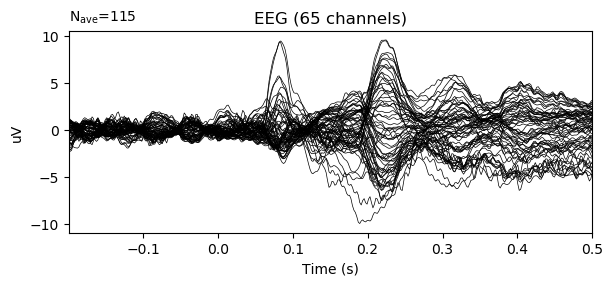

In [57]:
# plot ERPs of all channels for one of the conditions
evoked_dict['Coop/Win'].plot()

- Now use the same condition, but this time set the *picks*-argument to only plot the 6 midline frontal electrodes that we selected above. Note that you need a list of their indices, not just their names!

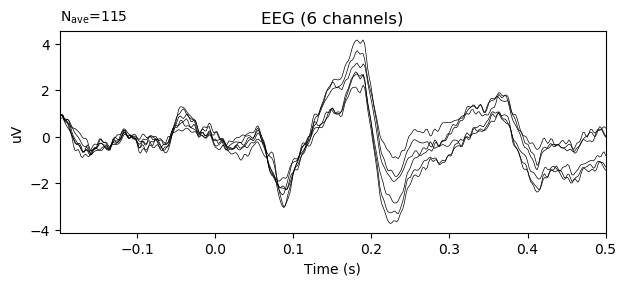

In [59]:
# plot ERPs for one of the conditions of selected channels
# make a list of channel indices
channels = ['F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2']
ch_indices = []
for i in channels:
    ch_indices.append(preprocessed.ch_names.index(i))

evoked_dict['Coop/Win'].plot(ch_indices)

Apart from the ERPs from individual channels, it’s always useful to see topographical maps of our data. It’s a nice way to see what’s going on across the whole head, showing us whether effects are broadly or narrowly distributed across the whole scalp.
- So now we want to plot the 2D topography of the evoked responses using [*mne.Evoked.plot_topomap()*](https://martinos.org/mne/stable/generated/mne.Evoked.html#mne.Evoked.plot_topomap). The first argument, *times* allows us to specify time instants (in seconds) for which topographies will be shown. Choose timepoints from 50 to 250ms with a step of 40ms with the help of *np.arrange()* and plot the topomaps.

In [103]:
# plot topography of evoked responses
times = np.arange(0.05, 0.25, 0.04)
for erp in evoked_dict:
    evoked_dict[erp].plot_topomap(times)

- Instead of showing topographies at specific time points, now compute averages of 50ms bins centered on these time points. As you might recognize that this slightly reduces the noise in the topographies.

In [84]:
# compute averages of 50ms bins to reduce noise
for erp in evoked_dict:
    evoked_dict[erp].plot_topomap(times, average=0.05)

Lastly, we want to compare the ERPs of the different social situations and the different outcome, seeing whether the event related activity within the selected frontal electrodes differs between these conditions. For this use the function *mne.viz.plot_compare_evokeds()*. 
- Again use *picks* to select the 6 midline frontal electrodes.  
- Apart from this, you also need to create two dictionaries: one assigning two different *colors* to the two possible outcomes (i.e. green and red for Win or Loose trials) and one assigning different *linestyles* to the different social situations (i.e. solid and dashed lines for either Cooporation or Competition).
- Now plot the ERPs with the *plot_compare_evokeds* command. You should get a plot with 4 lines (dashed/red, dashed/green, solid/red, solid/green). 

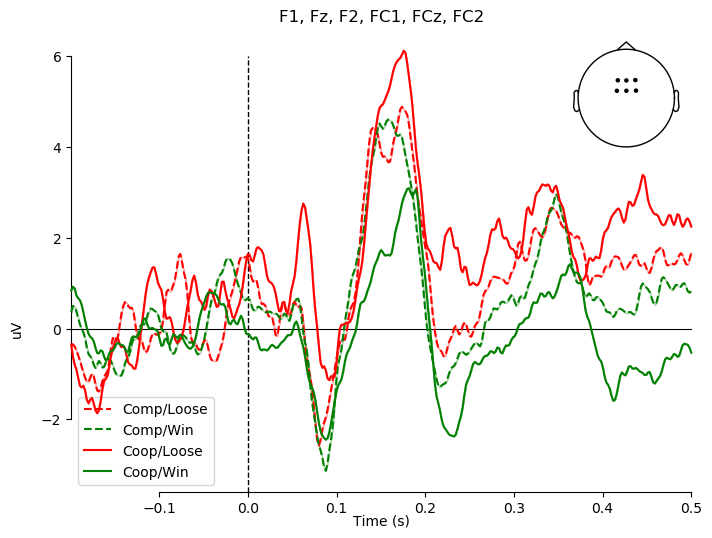

In [83]:
# selection of frontal electrodes
channels = ['F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2']
ch_indices = []
for i in channels:
    ch_indices.append(preprocessed.ch_names.index(i))

# create dictionaries for color and linestyle
colors = {'Win':'green', 'Loose':'red'}
linestyles = {'Coop':'solid', 'Comp':'dashed'}

# compare ERPs
mne.viz.plot_compare_evokeds(evoked_dict, pick, colors=colors, linestyles=linestyles)

## Citation

[Czeszumski, A., Ehinger, B., Wahn, B., and Knig, P. (2019). *The social situation affects how we process feedback about our actions*. Frontiers in Psychology, 10:361.](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.00361/full)